In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

sys.path.append(os.path.abspath("C:/Users/brf337/Desktop/Rasch package/RaschPy/RaschPy"))
import __init__ as Rasch

In [4]:
#Read data from data.csv and specify separator
data = pd.read_csv('data.csv', sep = '\t').dropna()

# Visualize the data
data.head()

# Subset the data to only include the first 10 items. That is to only include the questions (first 10 columns)
data_subset = data.iloc[:, 0:10]

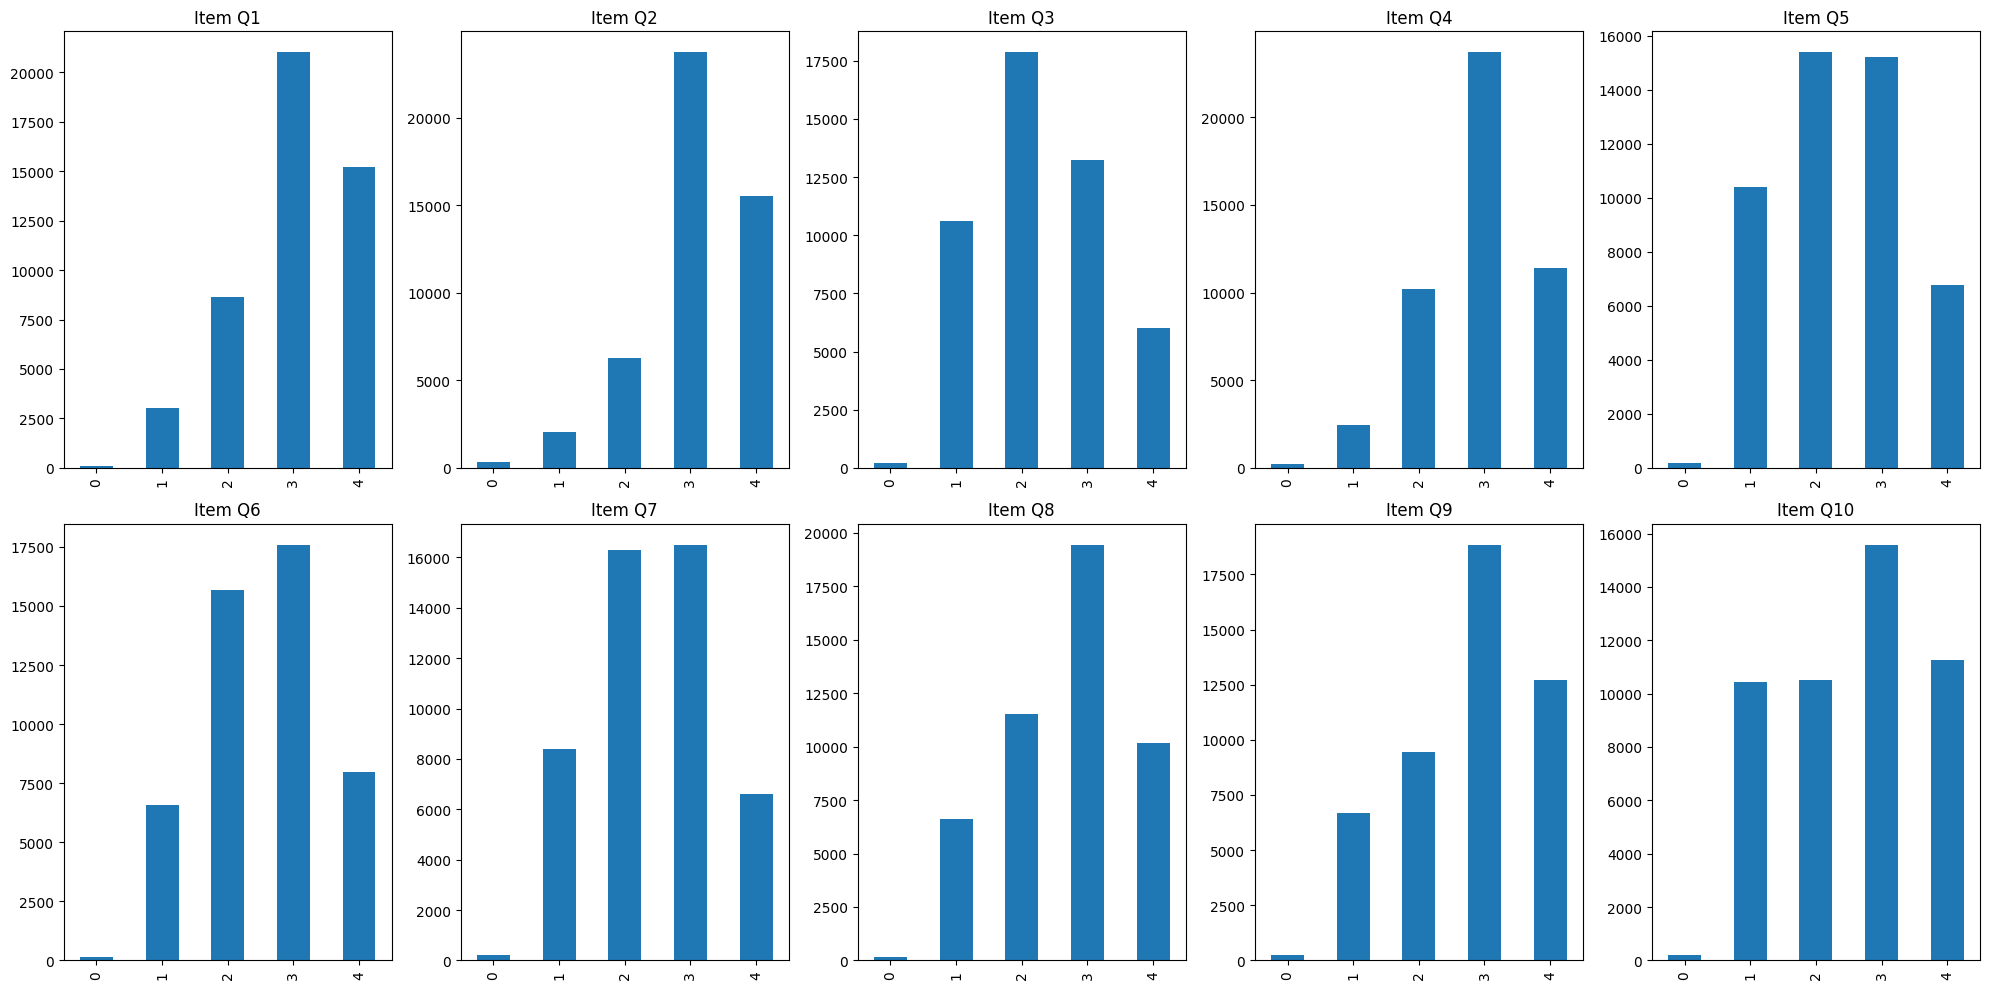

In [5]:
# Initialize an empty dictionary to store the counts
counts = {}
for column in data_subset.columns:
    counts[column] = data_subset[column].value_counts()

# Restructure the dictionary to be orded by item
counts_dataframe = pd.DataFrame(counts)


# Plot the counts as a bar chart ordered by items for each item and display in a grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.ravel()
for i, (column, items) in enumerate(counts_dataframe.items()):
    items.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Item {column}')
plt.tight_layout()
plt.show()

We wish to fit a Rasch Model to the data. We wish to try both a dichotomous and a polytomous Rasch model. To fit the dichotomous model we need to make the data binary. We also need to clean the data slightly. That is, we remove rows with missing values and zeros. Then we create a new data set where question values larger than or equal to 3 are set 1 and all other values are set to 0.

In [7]:
# Data prepping

# First we remove all rows with missing values or zeros
cleaned_subset = data_subset[(data_subset != 0).all(axis=1)]

# We then create a binary dataset setting all values above 2 to 1 and all other values to 0
binary_data = cleaned_subset.copy()
binary_data[binary_data <= 2] = 0
binary_data[binary_data > 2] = 1

# The dichotomous Rasch model
Having prepared the data we fit a Rasch model. The first step is to create an object of class `SLM` from a pandas dataframe of dichotomously scored data for analysis. This is always required before running an analysis.

The `SLM()` function takes inputs:
- `dataframe`: A pandas dataframe with items as columns and persons as index.
- `extreme_persons`: if `False`, all persons with extreme scores (all responses correct or all responses incorrect) are removed from the response dataframe. Default is `extreme_persons=True`.
- `no_of_classes`: Integer: the number of classes of persons grouped by ability for overplotting observed responses on theoretical curves. Default is `no_of_classes=5`.

To run the analysis we, we run methods defined on the `SLM` object. The performed analysis is then stored as an attribute in the `SLM` object. The `SLM` object has several attributes all of which can be found at https://github.com/MarkElliott999/RaschPy/blob/main/RaschPy_Manual.pdf chapter 3.

In [8]:
rasch_model_binary = Rasch.SLM(binary_data)
rasch_model_binary

## Core functions

### `cat_prob`
Category probability function. Attribute to calculate the probability $P(X_{nt} = k)$ of scoring $k$ from a persons ability and item difficulty. For a person $n$ with ability $\beta_n$ attempting an item $i$ with difficulty $\delta_t$, the probability of obtaining a score of $k$ is given by: 

$$P(X_{nt} = k) = \frac{e^{k(\beta_n - \delta_i)}}{1 + e^{\beta_n - \delta_i}}$$

The method is called with `self.cat_prob(ability, difficulty, category)`.

In [15]:
rasch_model_binary.cat_prob(ability = 0.5, difficulty = 0, category = 0)

0.3775406687981454

### `exp_score`
Expected score function. Attribute to calculate the expected score $E(X_{nt})$ from a persons ability and item difficulty. The expected score is given by: 

$$E(X_{nt}) = \sum_{k = 0}^1 k P(X_{nt} = k)$$

The method is called with `self.exp_score(ability, difficulty)`.

In [16]:
rasch_model_binary.exp_score(ability = 0.5, difficulty = 0)

0.6224593312018546

### `variance`
Variance function. Attribute to calculate the variance of the score $V(X_{nt})$ from a persons ability and item difficulty. The variance of the score is given by: 

$$V(X_{nt}) = \sum_{k = 0}^1 P(X_{nt} = k)(k - E(X_{nt}))^2$$

The method is called with `self.variance(ability, difficulty)`.

In [17]:
rasch_model_binary.variance(ability = 0.5, difficulty = 0)

0.2350037122015945

### `kurtosis`
Kurtosis function. Attribute to calculate the kurtosis of the score $V(X_{nt})$ from a persons ability and item difficulty. The kurtosis of the score is given by: 

$$\kappa(X_{nt}) = \sum_{k = 0}^1 P(X_{nt} = k)(k - E(X_{nt}))^4$$

The method is called with `self.kurtosis(ability, difficulty)`.

In [18]:
rasch_model_binary.kurtosis(ability = 0.5, difficulty = 0)

0.06932347795600494

## Parameter estimation

### `calibrate`
Produces item difficulty estimates using PAIR (Choppin, 1968, 1985), eigenvector method (Garner & Engelhard,
2002) or related conditional pairwise methods.

*Usage*

`self.calibrate(constant=0.1, method='cos', matrix power=3, log lik tol=0.000001)`

- `constant`: Float: additive smoothing constant (Elliott & Buttery, 2022b, https://journals.sagepub.com/doi/full/10.1177/00131644211046253). Default value is `constant=0.1`.
- `method`: String: method for derivation of vector of estimates from pairwise reciprocal matrix (Elliott & Buttery, 2022b:991–992). Options are `'ls'`  for least squares (Choppin, 1968, 1985), `'evm'` for the eigenvector method(Garner & Engelhard, 2002), `'cos'` for cosine similarity (Kou & Lin, 2014) or `'log-lik'` for (iterative) log-likelihood (Bradley & Terry, 1952). Default is `method='cos'`.
- `matrix_power`: Integer: power to which conditional category response frequency matrix (Elliott & Buttery, 2022b:991) is raised. Each additional power increases the number of indirect pairwise comparisons (Choppin, 1985; Elliott & Buttery, 2022b).
- `log_lik_tol`: Float: convergence stopping criterion for log-likelihood method. Ignored for other methods.


_Returns_

Attribute `self.diffs`: a pandas series of item difficulty estimates with the item names as keys and estimates as values.

In [14]:
rasch_model_binary.calibrate(method = "cos", matrix_power=1)
rasch_model_binary.diffs

Q1    -0.715828
Q2    -1.182166
Q3     0.956002
Q4    -0.581529
Q5     0.574231
Q6     0.584071
Q7     0.890824
Q8    -0.176661
Q9    -0.453693
Q10    0.104748
dtype: float64

In [38]:
rasch_model_binary.calibrate(method = "cos", matrix_power=2)
rasch_model_binary.diffs

Q1    -0.651097
Q2    -1.095560
Q3     0.870030
Q4    -0.528840
Q5     0.588749
Q6     0.437348
Q7     0.672006
Q8    -0.098517
Q9    -0.336753
Q10    0.142633
dtype: float64

In [41]:
rasch_model_binary.calibrate(method = "cos", matrix_power=3)
rasch_model_binary.diffs

Q1    -0.611633
Q2    -1.056436
Q3     0.794298
Q4    -0.496881
Q5     0.555392
Q6     0.419648
Q7     0.631568
Q8    -0.078535
Q9    -0.305173
Q10    0.147754
dtype: float64

In [29]:

rasch_model_binary.calibrate(method='log-lik', log_lik_tol=0.00000001)
rasch_model_binary.diffs

Q1    -0.531808
Q2    -0.889802
Q3     0.707012
Q4    -0.444323
Q5     0.491291
Q6     0.344581
Q7     0.526850
Q8    -0.078994
Q9    -0.262066
Q10    0.137260
dtype: float64

In [36]:
rasch_model_binary.calibrate(method='evm', log_lik_tol=0.00000001)
rasch_model_binary.diffs

Q1    -0.647652
Q2    -1.100362
Q3     0.843450
Q4    -0.512640
Q5     0.601312
Q6     0.394459
Q7     0.604002
Q8    -0.052195
Q9    -0.304579
Q10    0.174205
dtype: float64

### `std_errors`
Produces bootstrapped estimates for the standard errors of item difficulty estimates.

*Usage*
`self.std errors(interval=None, no_of_samples=100, constant=0.1, method='cos', matrix power=3, log lik tol=0.000001)`


- `interval`: Float. Empirical interval to define quantiles of estimates from bootstrap samples, as an alternative to a confidence interval. Defines a central interval of proportion p to determine upper and lower bounds of 1−(1−p)/2 and (1−p)/2, e.g. `interval=0.9` defines quantiles at 2.5% and 97.5%. More stable with larger numbers of bootstrap samples. Default is `interval=None`.
- `no_of_samples`: Integer: Number of bootstrap samples to generate. More samples lead to more accurate standard error estimates, but take correspondingly longer to compute. Default is no of `samples=100`.
- constant Float: additive smoothing constant (Elliott & Buttery, 2022b). Default value is `constant=0.1`.
- `method`: String: method for derivation of vector of estimates from pairwise reciprocal matrix (Elliott & Buttery, 2022b:991–992). Options are `'ls'` for least squares (Choppin, 1968, 1985), `'evm'` for the eigenvector method (Garner & Engelhard, 2002), `'cos'` for cosine similarity (Kou & Lin, 2014) or `'log-lik'` for (iterative) log-likelihood (Bradley & Terry, 1952). Default is `method='cos'`.
- `matrix_power`: Integer: power to which conditional category response frequency matrix
(Elliott & Buttery, 2022b:991) is raised. Each additional power increases
the number of indirect pairwise comparisons (Choppin, 1985; Elliott &
Buttery, 2022b).
- `log_lik_tol`: Float: convergence stopping criterion for log-likelihood method. Ignored for other methods.



_Returns_
- `self.item_se` pandas series: item names as keys and item standard errors as values.
- `self.item_bootstrap` pandas dataframe: Contains the full bootstrap results, with a row for each bootstrap sample and a column for each item estimate.

If `interval` is specified, also returns:
- `self.item_low` Float: The lower bound of the specified interval.
- `self.item_high` Float: The upper bound of the specified interval.

In [44]:
rasch_model_binary.std_errors(interval=0.95, no_of_samples=200)
rasch_model_binary.item_se

Q1     0.009422
Q2     0.011001
Q3     0.008179
Q4     0.008519
Q5     0.008280
Q6     0.007387
Q7     0.007444
Q8     0.008107
Q9     0.008639
Q10    0.008077
dtype: float64

In [46]:
rasch_model_binary.item_bootstrap

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
Sample 1,-0.618468,-1.060992,0.791006,-0.494545,0.549756,0.426725,0.634093,-0.078700,-0.299940,0.151065
Sample 2,-0.619568,-1.041978,0.783211,-0.500199,0.547723,0.425245,0.631081,-0.083830,-0.302715,0.161030
Sample 3,-0.619844,-1.031593,0.798748,-0.491426,0.541421,0.431276,0.633149,-0.091172,-0.314419,0.143861
Sample 4,-0.630923,-1.068818,0.793317,-0.513729,0.560712,0.439262,0.631649,-0.068792,-0.295163,0.152486
Sample 5,-0.604432,-1.075987,0.791091,-0.489167,0.546336,0.416874,0.640515,-0.072186,-0.299969,0.146925
...,...,...,...,...,...,...,...,...,...,...
Sample 196,-0.611708,-1.052594,0.792109,-0.499600,0.560128,0.415959,0.625422,-0.084925,-0.292989,0.148198
Sample 197,-0.611440,-1.047360,0.784623,-0.480267,0.545312,0.427734,0.629238,-0.076827,-0.316588,0.145574
Sample 198,-0.611079,-1.036038,0.789264,-0.489168,0.551990,0.424060,0.623838,-0.084737,-0.314564,0.146433
Sample 199,-0.609529,-1.066647,0.783717,-0.483708,0.557168,0.417304,0.624550,-0.079177,-0.292978,0.149300


In [47]:
rasch_model_binary.item_low

Q1    -0.632705
Q2    -1.076205
Q3     0.776691
Q4    -0.512859
Q5     0.539956
Q6     0.406747
Q7     0.619103
Q8    -0.093991
Q9    -0.321970
Q10    0.131994
dtype: float64

In [48]:
rasch_model_binary.item_high

Q1    -0.592895
Q2    -1.035970
Q3     0.810227
Q4    -0.479206
Q5     0.570871
Q6     0.436818
Q7     0.647537
Q8    -0.062890
Q9    -0.289167
Q10    0.162310
dtype: float64

### `abil`
Generates an ability estimate for a person using the Newton-Raphson method to produce a maximum likelihood estimate, with optional Warm bias correction (Warm, 1989).


_Usage_
`self.abil(person, items=None, warm_corr=True, tolerance=1e-07, max_iters=100, ext_score_adjustment=0.5)`


- `person` String: The person name for the ability being estimated.
- `items` List: List of names of a subset of items, based on which to generate the ability estimate. Default is items=None, which generates an ability based on the full set of items. Only use when an estimate based on a subset of items is required.
- `warm_corr` Boolean: if True, Warm's bias correction (Warm, 1989) is applied to the estimate. Default is `warm_corr=True`. 
- `tolerance` Float: convergence stopping criterion for Newton-Raphson iterations. Default is `tolerance=1e-07`.
- `max_iters` Integer: maximum number of Newton-Raphson iterations. Default is `max_iters=100`.
- `ext_score_adjustment` Float: Value in range (0, 1) to ensure a estimate is returned if the person has an extreme score (all items responded to are correct or incorrect). Since there is no finite ML ability estimate for extreme scores, this adjusts the person's score to `ext_score_adjustment` (if zero) or the maximum possible score minus `ext_score_adjustment` (if maximum score) before estimating ability.


_Returns_
Float: person ability estimate.

In [56]:
rasch_model_binary.abil(0) # Estimated ability of 1st person

np.float64(1.3066738358310965)

In [57]:
rasch_model_binary.abil(1) # Estimated ability of 2nd person

np.float64(0.4048118598895697)

In [58]:
rasch_model_binary.abil(2) # Estimated ability of 3rd person

np.float64(0.8272507109752409)

### `person_abils`

Generates ability estimates for all persons using the Newton-Raphson method to produce maximum likelihood estimates, with optional Warm bias correction (Warm, 1989).


Usage
`self.person_abils(items=None, warm_corr=True, tolerance=1e-07, max_iters=100, ext_score_adjustment=0.5)`



Arguments
- `items` List: List of names of a subset of items, based on which to generate the ability estimate. Default is `items=None`, which generates an ability based on the full set of items. Only use when an estimate based on a subset of items is required.
- warm_corr Boolean: if True, Warm's bias correction (Warm, 1989) is applied to the estimate. Default is `warm_corr=True`.
- `tolerance` Float: convergence stopping criterion for Newton-Raphson iterations. Default is `tolerance=1e-07`.
- `max_iters` Integer: maximum number of Newton-Raphson iterations. Default is `max_iters=100`.
- `ext_score_adjustment` Float: Value in range (0, 1) to ensure a estimate is returned if the person has an extreme score (all items responded to are correct or incorrect). Since there is no finite ML ability estimate for extreme scores, this adjusts the person's score to `ext_score_adjustment` (if zero) or the maximum possible score minus `ext_score_adjustment` (if maximum score) before estimating ability.

Returns
Attribute `self.person_abilities`: pandas series with person names as keys and ability estimates as values.

In [ ]:
rasch_model_binary.person_abils()

In [63]:
rasch_model_binary.person_abilities

0        1.306674
1        0.404812
2        0.827251
3        0.827251
4        0.005454
           ...   
47969    0.005454
47970   -0.395179
47971   -0.395179
47972    0.827251
47973    0.404812
Length: 46542, dtype: float64

### `score_abil`

Generates an ability estimate for a given raw scoreon responses to a given set of items using the Newton-Raphson method to produce a maximum likelihood estimate, with optional Warm bias correction (Warm,1989).


_Usage_

`self.score abil(score, items=None, warm corr=True, tolerance=1e-07, max_iters=100, ext_score_adjustment=0.5)`


_Arguments_

- `score` Integer: The raw score for which ability is being estimated. 
- `items` List: List of names of a subset of items, based on which to generate the ability estimate. Default is `items=None`, which generates an ability based on the full set of items. Only use when an estimate based on a subset of items is required.
- `warm_corr` Boolean: if True, Warm's bias correction (Warm, 1989) is applied to the estimate. Default is warm `corr=True`.
- `tolerance` Float: convergence stopping criterion for Newton-Raphson iterations. Default is `tolerance=1e-07`.
- `max_iters` Integer: maximum number of Newton-Raphson iterations. Default is `max_iters=100`.
- `ext_score_adjustment` Float: Value in range (0, 1) to ensure a estimate is returned if the score is extreme (all items responded to are correct or incorrect). Since there is no finite ML ability estimate for extreme scores, this adjusts the score to `ext_score_adjustment` (if zero) or the maximum possible score minus `ext_score_adjustment` (if maximum score) before estimating ability.


_Returns_
pandas series with raw scores as keys and person ability estimates as values.

In [90]:
rasch_model_binary.score_abil(4)

-0.39517850831092793

## Statistical output

It is possible to get summary dataframes for both the item difficulty and person scores. The methods use many of the same arguments as presented in the previous section, so I refrain from repeating them here but refer to https://github.com/MarkElliott999/RaschPy/blob/main/RaschPy_Manual.pdf for additional details. A few examples are given below:

In [9]:
# To get the item statistics
rasch_model_binary.item_stats_df(full=False, # Full table with all available statistics is produced if True
                                 zstd=False, # infit and outfit standardized z-score are reported alongside mean square statistics if True
                                 disc=False, # Item discrimination is reported if True
                                 point_measure_corr=False, # Point-biseriel correlation between person ability and item score together with the expected value is reported if True
                                 dp=3, warm_corr=True,
                                 tolerance=1e-07, 
                                 max_iters=100, 
                                 ext_score_adjustment=0.5, 
                                 method='cos',
                                 constant=0.1, 
                                 no_of_samples=100,
                                 interval=None)

C:\Users\brf337\Desktop\Rasch package\RaschPy\RaschPy\__init__.py:1266: RuntimeWarning: invalid value encountered in sqrt
  self.psi = (np.sqrt(np.var(self.person_abilities) - (self.rsem_vector ** 2).mean()) /


In [10]:
rasch_model_binary.item_stats

,Estimate,SE,Count,Facility,Infit MS,Outfit MS
Q1,-0.612,0.008,46542,0.757,0.899,0.858
Q2,-1.056,0.009,46542,0.825,0.861,0.784
Q3,0.794,0.007,46542,0.403,1.012,1.024
Q4,-0.497,0.009,46542,0.736,0.918,0.899
Q5,0.555,0.008,46542,0.461,1.000,1.004
Q6,0.420,0.007,46542,0.535,1.076,1.071
Q7,0.632,0.008,46542,0.483,1.098,1.093
Q8,-0.079,0.009,46542,0.620,0.935,0.916
Q9,-0.305,0.008,46542,0.662,0.900,0.846
Q10,0.148,0.007,46542,0.563,0.926,0.906


findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.


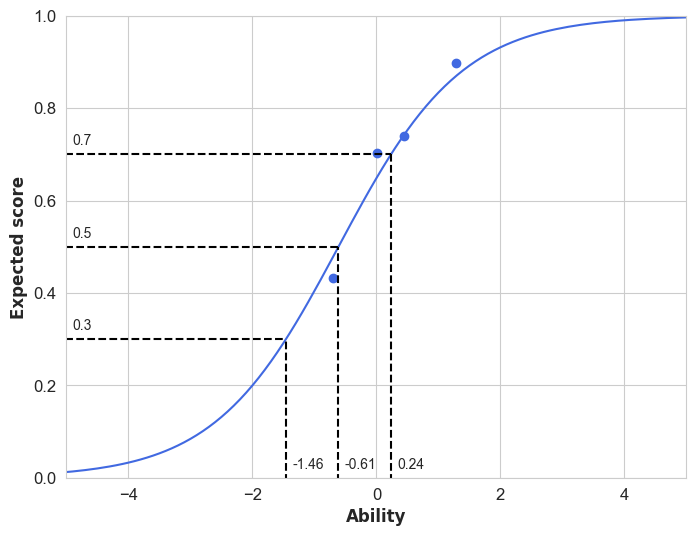

In [18]:
rasch_model_binary.icc("Q1", obs = True, score_labels= True, score_lines = [0.3, 0.5, 0.7], no_of_classes=5)

In [9]:
rasch_model_binary.person_stats_df()
rasch_model_binary.person_stats

RaschBinaryPersonSummaryDataFrame = rasch_model_binary.person_stats[['Estimate', 'Score', 'CSEM']].drop_duplicates().sort_values(by='Score').reset_index(drop=True)
RaschBinaryPersonSummaryDataFrame

,Estimate,Score,CSEM
0,-2.167,0,NaN
1,-1.902,1,0.921
2,-1.307,2,0.777
3,-0.821,3,0.704
4,-0.395,4,0.669
5,0.005,5,0.658
6,0.405,6,0.668
7,0.827,7,0.702
8,1.307,8,0.773
9,1.892,9,0.915


# PCM
We now fit the PCM in Python. First step is to create an object of class PCM:

In [14]:
data_poly = cleaned_subset

PCM_model = Rasch.PCM(data_poly)
PCM_model.item_stats_df()

C:\Users\brf337\Desktop\Rasch package\RaschPy\RaschPy\__init__.py:2577: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in range(self.max_score_vector[item_1])]
C:\Users\brf337\Desktop\Rasch package\RaschPy\RaschPy\__init__.py:2576: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j in range(self.max_score_vector[item_2])]
C:\Users\brf337\Desktop\Rasch package\RaschPy\RaschPy\__init__.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

In [15]:
PCM_model.item_stats

,Estimate,SE,Count,Facility,Infit MS,Outfit MS,Disordered
Q1,-0.174,0.002,46542,0.753,1.139,1.126,
Q2,-0.194,0.003,46542,0.777,1.130,1.106,
Q3,0.168,0.003,46542,0.577,0.986,1.003,
Q4,-0.091,0.003,46542,0.731,1.121,1.109,
Q5,0.138,0.003,46542,0.596,0.984,0.993,
Q6,0.059,0.003,46542,0.641,1.207,1.205,
Q7,0.124,0.003,46542,0.612,1.213,1.214,
Q8,0.021,0.003,46542,0.674,0.931,0.932,
Q9,-0.042,0.002,46542,0.697,0.890,0.874,True
Q10,-0.009,0.002,46542,0.645,0.917,0.913,True


findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.


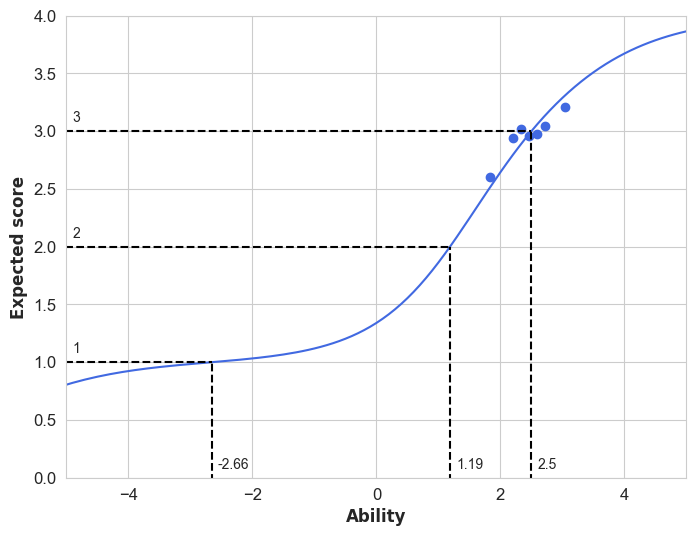

In [17]:
PCM_model.icc("Q1", obs = True, score_labels= True, score_lines = [1, 2, 3], no_of_classes=7)